# 🌐 Connect Colab to Google Drive

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/
    %cd ANDL_HOMEWORK2_LINK
    home_path = "./models/enrico"
    GOOGLE = True
except:
    home_path = "./"
    GOOGLE = False

Mounted at /gdrive
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/1vsTygZGT_kAzNeU8X79sw_R-6RcOwzqm/Homework 2


# ⚙️ Import Libraries

In [ ]:
%pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.9 MB/s eta 0:00:00


TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


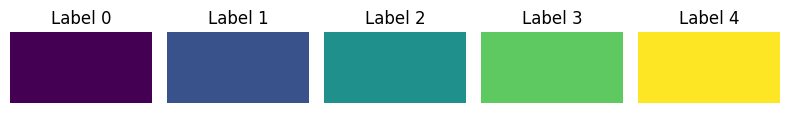

In [ ]:
import numpy as np
import pandas as pd
import os
import psutil
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split


import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import albumentations as A
import keras_cv

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

seed = 50


def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

colormap = create_segmentation_colormap(5)

def display_images(images, labels, num_images):
    mod_labels = labels[..., np.newaxis]
    num_images = min(num_images, len(images))

    if num_images == 0:
      return

    random_indices = np.random.choice(len(images), num_images, replace=False)

    num_images *= 2

    cols = min(num_images, 2) * 2 # Limit to 5 columns for readability
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed

    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    axf = ax.flatten()

    for ax in axf:
        ax.axis('off')

    for i, idx in enumerate(random_indices):
        axf[(i * 2)].imshow(images[idx].squeeze(), cmap='gray')
        col_lbl = apply_colormap(mod_labels[idx], colormap)
        axf[(i * 2) + 1].imshow(col_lbl)

    plt.tight_layout()
    plt.show()
    plt.close()

showcolor = np.array([np.full((64, 128, 1), fill_value=i, dtype=np.int32) for i in range(5)]) / 1.0

plt.figure(figsize=(8, 4))

for i, image in enumerate(showcolor):
    image = tf.expand_dims(image,0)
    col_img = apply_colormap(image, colormap)

    plt.subplot(1, 5, i + 1)
    plt.imshow(col_img)
    plt.title(f"Label {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
TEST_SIZE = 0.2
BATCH_SIZE = 4
ALPHA = 0.33
FILT_THRS = 0.9
DISPL_IMG = 10
AUGM_N = 4

# ⏳ Load the Data

In [ ]:
# Load the NPZ file
data = np.load('./dataset/cleaned_training_dataset.npz',allow_pickle=True)

# Print the keys in the file to see what arrays are stored
print("Keys in the npz file:", data.files)

#Store Data in Arrays
images_data = data["images"]
norm_images_data = images_data[..., np.newaxis]
labels_data = data["labels"]
norm_labels_data = labels_data[..., np.newaxis]

print("Number of Images :",len(images_data))
print("Labels :",len(labels_data))

print("Shape of Images Array :", images_data.shape)
print("Shape of Labels Array :", labels_data.shape)


Keys in the npz file: ['images', 'labels']
Number of Images : 2505
Labels : 2505
Shape of Images Array : (2505, 64, 128)
Shape of Labels Array : (2505, 64, 128)


# ✨ Augment Dataset

In [ ]:
def is_mostly_zero(label, threshold=1.1):
    return (np.sum(label < 1.0) / label.size) >= threshold


def remove_blank_labels(images, labels, zero_threshold=0):
    filtered_images = []
    filtered_labels = []
    final_img = []
    final_lbl = []

    for image, label in zip(images, labels):
        if not is_mostly_zero(label):
            final_img.append(image)
            final_lbl.append(label)
        else:
            filtered_images.append(image)
            filtered_labels.append(label)

    return np.array(final_img), np.array(final_lbl), np.array(filtered_images), np.array(filtered_labels)

def has_class(label, cl):
    return np.sum(label == cl) > 0

def remove_classed_labels(images, labels, cl):
    filtered_images = []
    filtered_labels = []
    final_img = []
    final_lbl = []

    for image, label in zip(images, labels):
        if not has_class(label, cl):
            final_img.append(image)
            final_lbl.append(label)
        else:
            filtered_images.append(image)
            filtered_labels.append(label)

    return np.array(final_img), np.array(final_lbl), np.array(filtered_images), np.array(filtered_labels)

In [ ]:
no_cl4_img, no_cl4_lbl, cl4_img, cl4_lbl = remove_classed_labels(norm_images_data, norm_labels_data, 4.0)
print(f"No CL4: {no_cl4_img.shape}")
print(f"CL4: {cl4_img.shape}")


passed_img, passed_lbl, filt_img, filt_lbl = remove_blank_labels(no_cl4_img, no_cl4_lbl, FILT_THRS)
print(f"Passed: {passed_img.shape}")
print(f"Filtered: {filt_img.shape}")


No CL4: (2442, 64, 128, 1)
CL4: (63, 64, 128, 1)
Passed: (2442, 64, 128, 1)
Filtered: (0,)


WITHOUT CL4


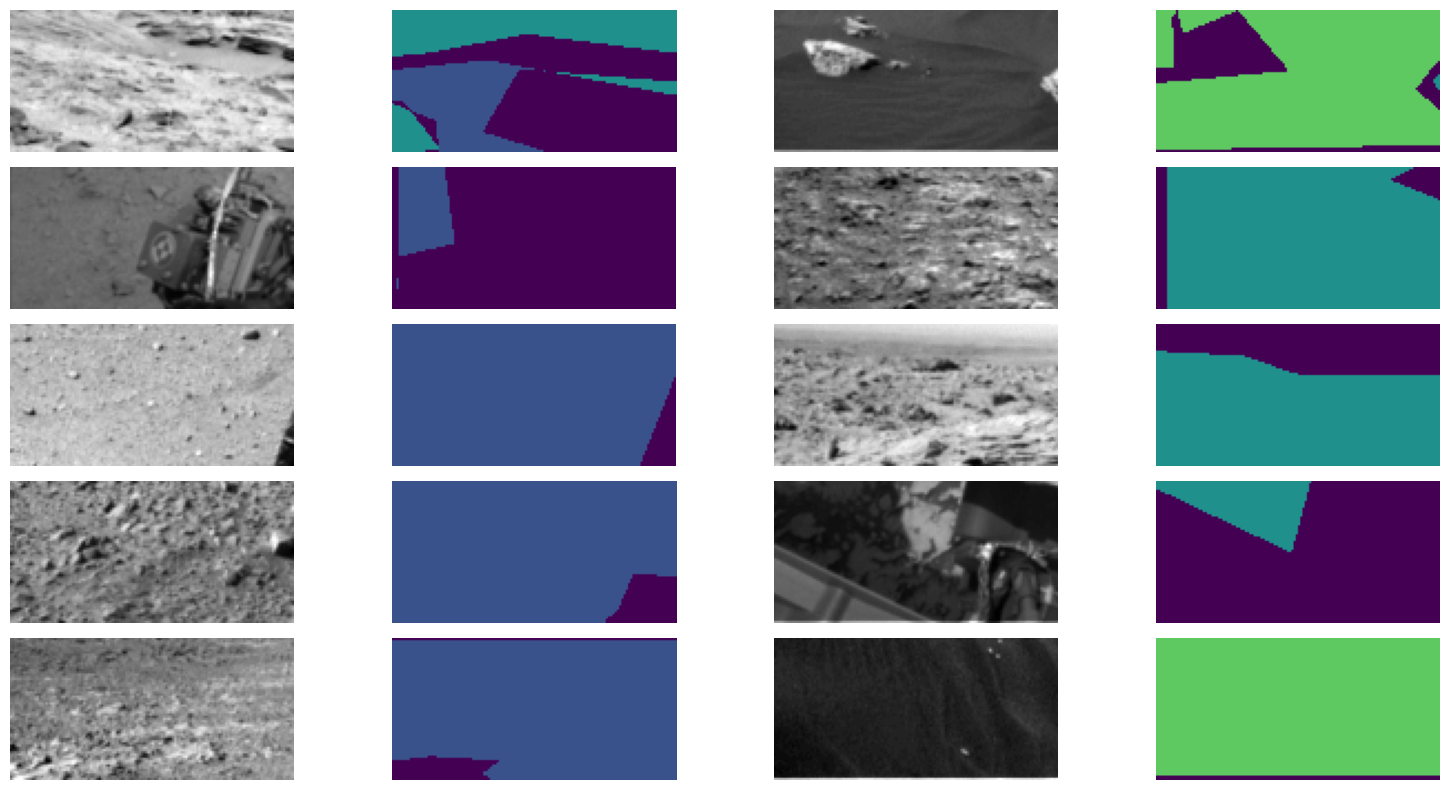

CL4


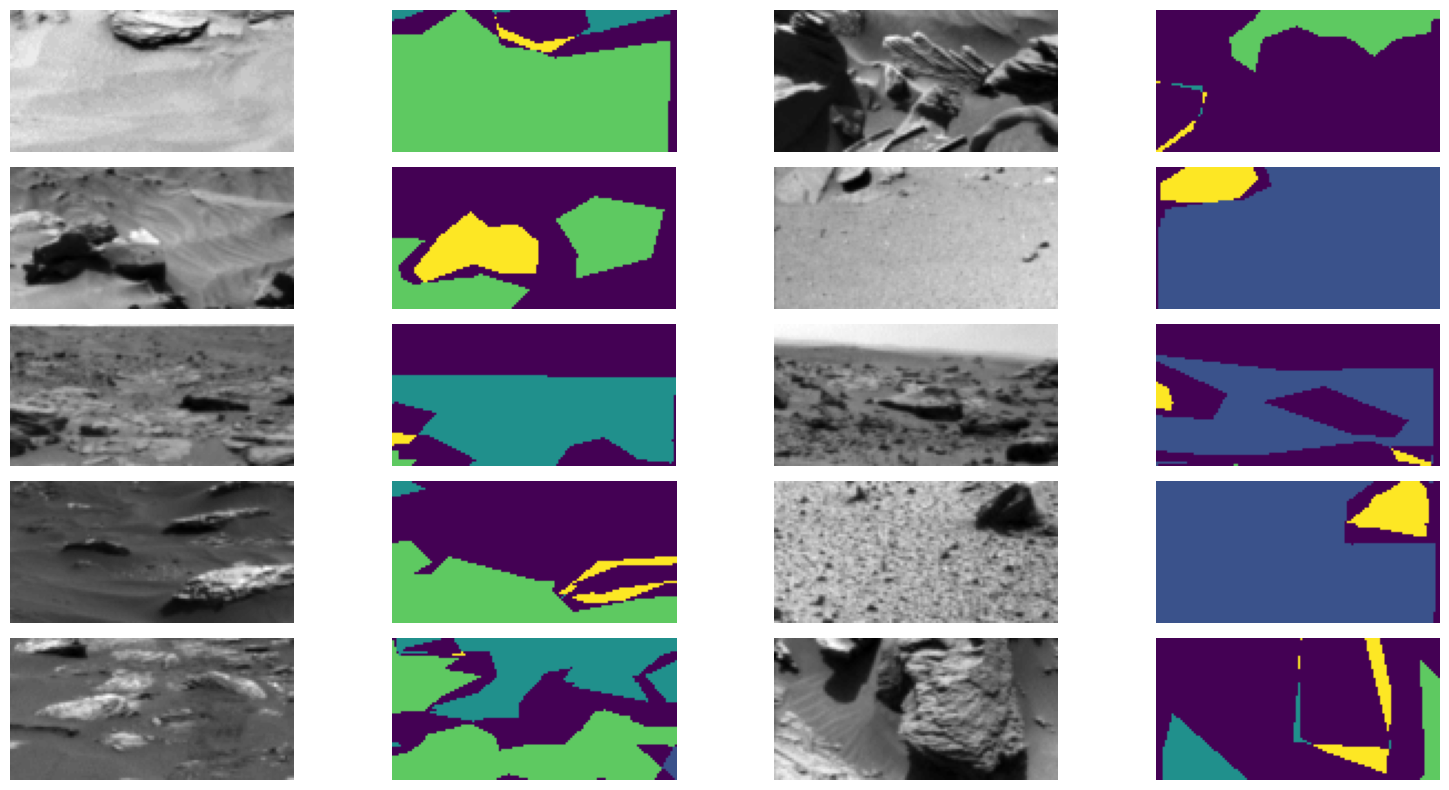

In [ ]:
print("WITHOUT CL4")
display_images(no_cl4_img, no_cl4_lbl, DISPL_IMG)
print("CL4")
display_images(cl4_img, cl4_lbl, DISPL_IMG)

del no_cl4_img, no_cl4_lbl

WITHOUT MOST BLANK


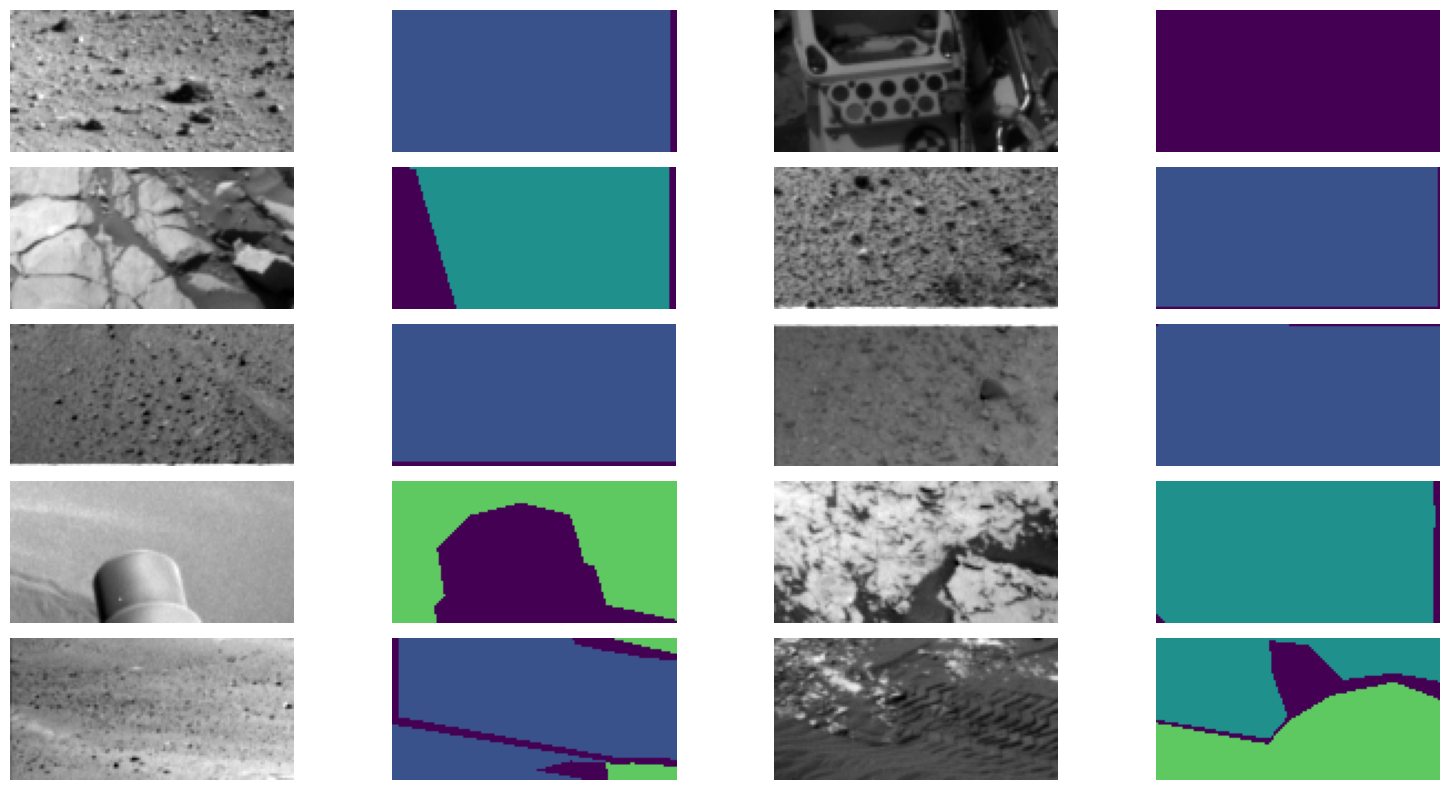

MOST BLANK


In [ ]:
print("WITHOUT MOST BLANK")
display_images(passed_img, passed_lbl, DISPL_IMG)
print("MOST BLANK")
display_images(filt_img, filt_lbl, DISPL_IMG)

del filt_img, filt_lbl

In [ ]:
# Split separately cl4 images and filtered one
train_cl4_img, val_cl4_img, train_cl4_lbl, val_cl4_lbl = train_test_split(
    cl4_img, cl4_lbl, test_size=TEST_SIZE/2, random_state=seed
)
del cl4_img, cl4_lbl

train_pass_img, val_pass_img, train_pass_lbl, val_pass_lbl = train_test_split(
    passed_img, passed_lbl, test_size=TEST_SIZE, random_state=seed
)
del passed_img, passed_lbl

# Then concatenate validation
val_img = np.concatenate([val_cl4_img, val_pass_img], axis=0)
val_lbl = np.concatenate([val_cl4_lbl, val_pass_lbl], axis=0)
del val_cl4_img, val_pass_img, val_cl4_lbl, val_pass_lbl

# Then shuffle trains
shuffle_idx = np.random.permutation(len(train_pass_img))
train_pass_img = train_pass_img[shuffle_idx]
train_pass_lbl = train_pass_lbl[shuffle_idx]

shuffle_idx = np.random.permutation(len(train_cl4_img))
train_cl4_img = train_cl4_img[shuffle_idx]
train_cl4_lbl = train_cl4_lbl[shuffle_idx]

print(f"Train: {train_pass_img.shape}, {train_cl4_img.shape}")
print(f"Val: {val_img.shape}")

Train: (1953, 64, 128, 1), (56, 64, 128, 1)
Val: (496, 64, 128, 1)


In [ ]:
to_save_img_val = val_img.reshape(val_img.shape[:-1])
to_save_lab_val = val_lbl.reshape(val_lbl.shape[:-1])

val_name = f"{home_path}/dataset/validation_{AUGM_N}.npz"
np.savez_compressed(val_name, images=to_save_img_val, labels=to_save_lab_val)
del val_img, val_lbl, to_save_img_val, to_save_lab_val

In [ ]:
augmentation_pipeline = A.Compose([
    # Geometric augmentations
    A.RandomSizedCrop(min_max_height=(50, 64), height=64, width=128, p=0.5),  # Randomly crop
    A.HorizontalFlip(p=0.5),  # Horizontal flip
    A.VerticalFlip(p=0.5),  # Vertical flip
    A.RandomRotate90(p=0.1),  # 90-degree rotation (optional)
    A.Rotate(limit=15, p=0.5),  # Random rotation within 15 degrees
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),  # Random shifts, scales, and rotations

    # Photometric augmentations
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Adjust brightness and contrast
    A.RandomGamma(p=0.3),  # Gamma correction for lighting variations

    # Optional noise injection
    A.Emboss(p=0.1),

    # Edge detection for texture enhancement
    A.Sharpen(p=0.3),  # Detect edges in terrain features

    # Resize and Normalize
    A.Resize(64, 128, always_apply=True),# Normalize pixel values to [-1, 1]
])

def augment(images, labels, ratio):
    augm_train_img = np.zeros((images.shape[0]*(ratio+1), 64, 128, 1))
    augm_train_lbl = np.zeros((labels.shape[0]*(ratio+1), 64, 128, 1))

    images = images / 255.0

    for i, (image, mask) in enumerate(zip(images, labels)):
        for j in range(ratio):
            augmented = augmentation_pipeline(image=image, mask=mask)
            augm_train_img[i*(ratio+1) + j], augm_train_lbl[i*(ratio+1) + j] = augmented["image"], augmented['mask']

        augm_train_img[i*(ratio+1) + ratio] = image
        augm_train_lbl[i*(ratio+1) + ratio] = mask

    augm_train_img = augm_train_img * 255.0

    shuffle_idx = np.random.permutation(len(augm_train_img))
    augm_train_img = augm_train_img[shuffle_idx]
    augm_train_lbl = augm_train_lbl[shuffle_idx]

    return augm_train_img, augm_train_lbl

In [ ]:
augm_pass_img, augm_pass_lbl = augment(train_pass_img, train_pass_lbl, AUGM_N)
augm_cl4_img, augm_cl4_lbl = augment(train_cl4_img, train_cl4_lbl, AUGM_N * 6)
del train_pass_img, train_pass_lbl, train_cl4_img, train_cl4_lbl

augm_img = np.concatenate([augm_pass_img, augm_cl4_img], axis=0)
augm_lbl = np.concatenate([augm_pass_lbl, augm_cl4_lbl], axis=0)
del augm_cl4_img, augm_pass_img, augm_cl4_lbl, augm_pass_lbl

shuffle_idx = np.random.permutation(len(augm_img))
augm_img = augm_img[shuffle_idx]
augm_lbl = augm_lbl[shuffle_idx]

print(f"Augmented: {augm_img.shape}")

Augmented: (11165, 64, 128, 1)


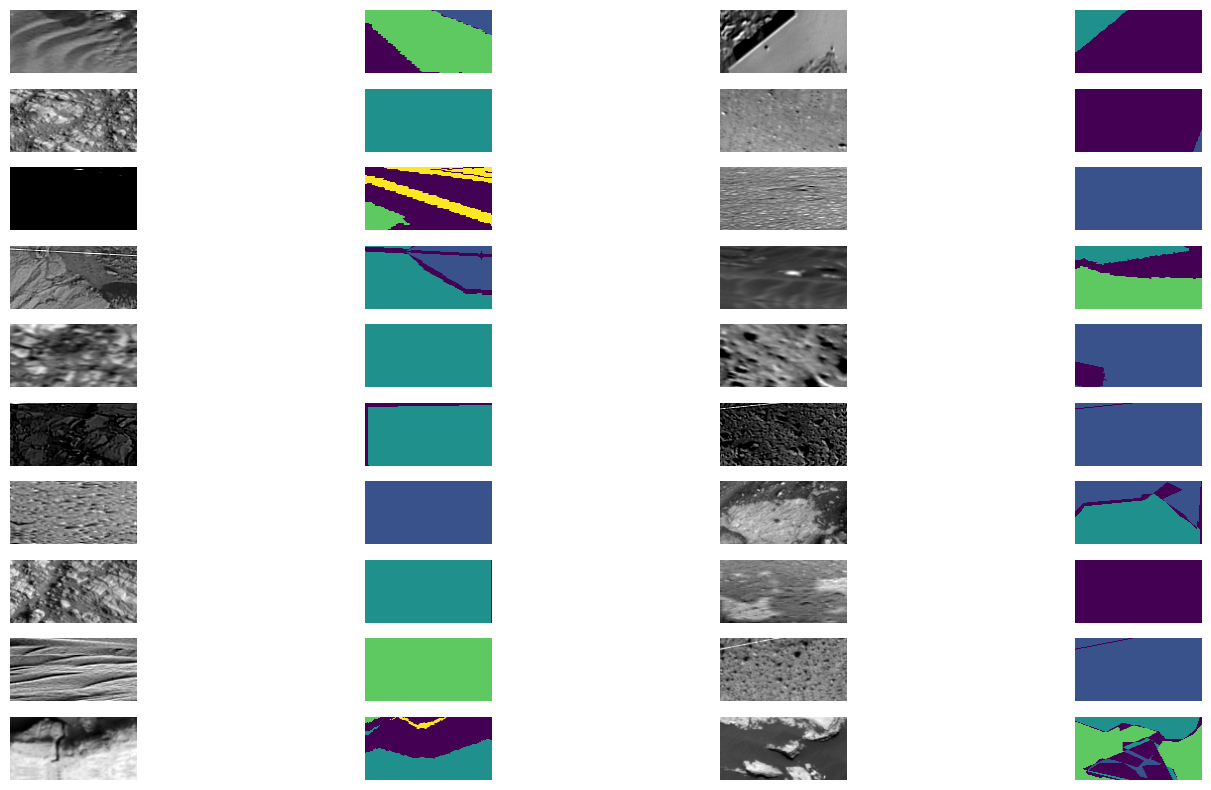

In [ ]:
display_images(augm_img, augm_lbl, DISPL_IMG*2)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def compute_segmentation_class_weights(masks, num_classes):
    flat_labels = masks.flatten()

    # Unique classes
    classes = np.unique(range(num_classes))

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=flat_labels)

    # Convert to a dictionary for easy access
    class_weight_dict = dict({(int(i)): float(weight) for i, weight in zip(classes, class_weights)})

    return class_weight_dict

def plot_normalized_class_distribution(class_weights, class_labels=None):
    # Extract class names and weights
    if class_labels is None:
        class_names = list(class_weights.keys())
    else:
        class_names = class_labels

    weights = np.array(list(class_weights.values()))

    reversed = np.array([weights[0]/a for a in weights])

    # Normalize weights to sum to 1
    normalized_weights = reversed / reversed.sum()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, normalized_weights, color='skyblue', edgecolor='black')
    plt.xlabel('Classes')
    plt.ylabel('Normalized Weight')
    plt.title('Normalized frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

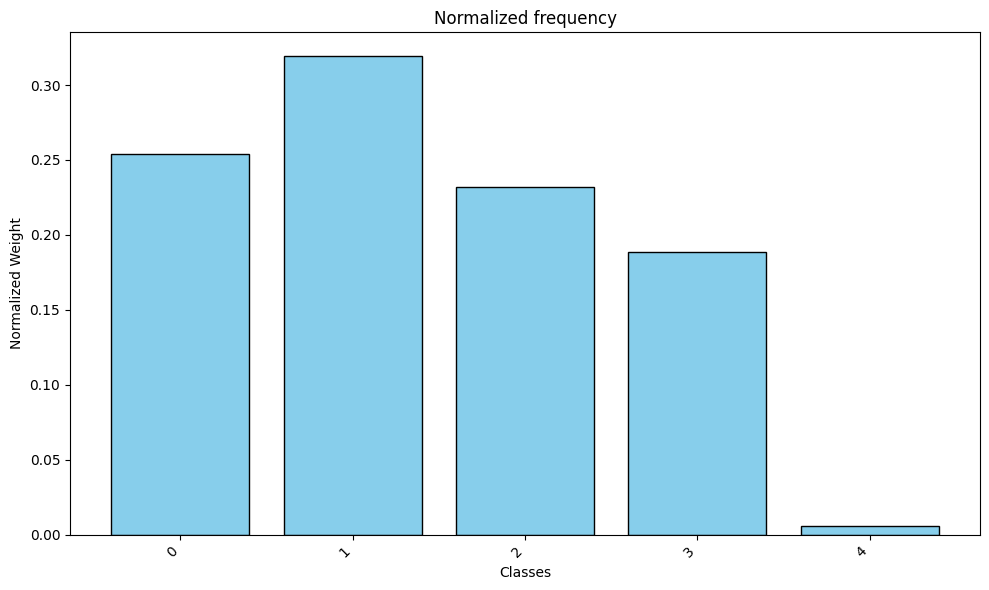

In [ ]:
weights = compute_segmentation_class_weights(augm_lbl, 5)
plot_normalized_class_distribution(weights)

In [ ]:
to_save_img = augm_lbl.reshape(augm_img.shape[:-1])
to_save_lab = augm_lbl.reshape(augm_lbl.shape[:-1])

img_arr = np.array(to_save_img)
lab_arr = np.array(to_save_lab)

train_name = f"{home_path}/dataset/training_{AUGM_N}.npz"
np.savez_compressed(train_name, images = img_arr, labels = lab_arr)